# Imports

In [47]:
import os
import torch
import torch.nn as nn
import numpy as np
from IPython import embed
from skimage import color
from PIL import Image
from torch.utils.data import Dataset, IterableDataset
from torchsummary import summary
from tqdm.notebook import trange, tqdm
from torch.nn.utils.clip_grad import clip_grad_norm_
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [3]:
#Pre processing of data to index rbg training data
def preProcessing(path, h=256, w=256):
  if not os.path.exists(path + "/train"):
    os.mkdir(path + "/train")
    os.mkdir(path + "/train/rgb")

  idx=0
  for filename in os.listdir(path):
    if not os.path.isdir(path + "/" + filename):
      
      #get RGB image, resize, and put in rgb folder
      rgb_img=Image.open(path + "/" + filename)
      rgb_img=rgb_img.resize((w, h))
      rgb_img.save(path + "/train/target/" + str(idx) + "_rgb.png")

      idx+=1


In [4]:
#Scafolding for Dataset
def myDataset(h=256, w=256, rgb2lab=True, zhangmodel=True, edmodel=False):
  def __init__(self, img_dir, transform):
    self.img_dir=img_dir
    self.transform=transform
    self.dataset_length = len(os.listdir(img_dir + "/train/rgb"))
    
    #Set up dataset so images are indexed
    preProcessing(img_dir, h, w)

    if zhangmodel:
      print("ZHANG MODEL")

    elif edmodel:
      print("ED MODEL")

    def __len__(self):
      return self.dataset_length

    def __getitem__(self, idx):
      #Get RGB image, resize, and transform it
      rgb_img=Image.open(self.img_dir + "/" + str(idx) + "_rgb.png")
      rgb_img=self.transform(rgb_img.resize((w, h)))

      #Get CIE-Lab equivalent of the RGB image
      clab_array=color.rgb2lab(np.asarray(rgb_img))
      clab_img=Image.fromarray(clab_array, mode="LAB")

      #Get greyscale CIE-Lab equivalent of the RGB image
      clab_grayimg=Image.fromarray(clab_array[:, :, 0], mode="LAB")

      data={'input':clab_grayimg, 'target':clab_img}

      return data
    

In [23]:
class zhangDataset(Dataset):
  def __init__(self, img_dir):
    self.img_dir=img_dir
    self.h = 32
    self.w = self.h 
    paths = os.listdir(self.img_dir)
    self.dataset_length = len(paths)
    self.paths = list(map(lambda x: os.path.join(self.img_dir, x), paths))

  def __len__(self):
    return self.dataset_length

  def __getitem__(self, idx):
    imagepath = self.paths[idx]
    imagefile = os.path.basename(imagepath)
    rgb_img = Image.open(imagepath)
    rgb_img = rgb_img.resize((self.w, self.h))
    #Get CIE-Lab equivalent of the RGB image
    clab_array=color.rgb2lab(np.asarray(rgb_img, dtype = np.float32))
    clab_img=Image.fromarray(clab_array, mode="LAB")

    #Get greyscale CIE-Lab equivalent of the RGB image
    clab_grayarray = clab_array[:, :, 0]
    clab_grayarray = clab_grayarray[np.newaxis,:, :]
    clab_grayimg=Image.fromarray(clab_array[:, :, 0], mode="LAB")

    clab_array = clab_array.transpose((2, 0, 1)) # (3, 256, 256)

    data={'input':clab_grayarray, 'target':clab_array}

    return data

# Model 1 ("Colorful Image Colorization" by Zhang et al.)

In [30]:
class BaseModel(nn.Module):
  '''
  A 8-blocks cnn model, each block has multiple cnn layer (22 in total)
  "prediction" in CIELAB space (L, a, b)
  For this model, it takes in "grayscale image" with only L value
  and it outputs a and b values
  '''
  def __init__(self, norm_layer = nn.BatchNorm2d):
    super(BaseModel, self).__init__()
    self.l_cent = 50
    self.l_norm = 100
    self.ab_norm = 110
    # layer 1
    self.layer1 = nn.Sequential(*[
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(True),
            norm_layer(64)])

    # layer 2
    self.layer2 = nn.Sequential(*[
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(True),
        nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),
        nn.ReLU(True),
        norm_layer(128)])

    # layer 3
    self.layer3 = nn.Sequential(*[
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(True),
        # nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
        # nn.ReLU(True),
        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),
        nn.ReLU(True),
        norm_layer(256)])

    # layer 4
    self.layer4 = nn.Sequential(*[
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(True),
        # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
        # nn.ReLU(True),
        # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
        # nn.ReLU(True),
        norm_layer(512)])

    # layer 5
    self.layer5 = nn.Sequential(*[
        # nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
        # nn.ReLU(True),
        # nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
        # nn.ReLU(True),
        nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
        nn.ReLU(True),
        # norm_layer(512)
        ])

    #layer 6
    self.layer6 = nn.Sequential(*[
        # nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
        # nn.ReLU(True),
        # nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
        # nn.ReLU(True),
        # nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
        # nn.ReLU(True),
        norm_layer(512),]
        )

    #layer 7
    self.layer7 = nn.Sequential(*[
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(True),
        # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
        # nn.ReLU(True),
        # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),
        # nn.ReLU(True),
        norm_layer(512),])

    #layer 8
    self.layer8 = nn.Sequential(*[
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),
        nn.ReLU(True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(True),
        # nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),
        # nn.ReLU(True),
        nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),])

    self.softmax = nn.Softmax(dim=1)
    # 2 means (a, b)
    self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
    self.upsample = nn.Upsample(scale_factor=4, mode='bilinear')
  
  def normalize_l(self, in_l):
    return (in_l-self.l_cent)/self.l_norm

  def forward(self, input_l):
    # model
    conv1_2 = self.layer1(self.normalize_l(input_l))
    conv2_2 = self.layer2(conv1_2)
    conv3_3 = self.layer3(conv2_2)
    conv4_3 = self.layer4(conv3_3)
    conv5_3 = self.layer5(conv4_3)
    conv6_3 = self.layer6(conv5_3)
    conv7_3 = self.layer7(conv6_3)
    conv8_3 = self.layer8(conv7_3)

    out_reg = self.model_out(self.softmax(conv8_3))

    # this is deal with nomalization
    # output is in [0,1] (ratio of a, b to L)
    # L ususally has a range [0, 100] (or 110)
    return self.ab_norm  *(self.upsample(out_reg))

# zhang Loss

In [ ]:
def RebalanceLoss

In [ ]:
def GetClassWeights

# Zhang training

In [ ]:
!unzip "/content/drive/MyDrive/ACV/Image Colorization Dataset.zip" -d "/content/"

In [38]:
dp_zip = "/content/drive/MyDrive/ACV/Image Colorization Dataset.zip"
dp_train_path = "/content/data/train_color"
dp_test_path = "/content/data/train_color"
dp_save_path = "/content/dp.ckpt"
zhang_train_dataset = zhangDataset(dp_train_path)
zhang_train_dataset, _ = random_split(zhang_train_dataset, [0.7, 0.3])
len(zhang_train_dataset)

3500

In [40]:
# Hyper parameters and others
lr = 1e-2
epochs = 6
batch_size = 8
criterion = None
if True:
  criterion = nn.MSELoss()
else:
  print("Not implemented")
zhangmodel = BaseModel()
optimizer = torch.optim.Adam(params=zhangmodel.parameters(), lr=lr)


In [41]:
def forward(x):
    # forward pass of the model
    res = zhangmodel(x)
    return res #res.transpose(1, 0)

def cal_loss(res, targets, pred_sizes, target_sizes):
    # calculate loss
    # loss = criterion(res, targets, pred_sizes, target_sizes)
    # print(res.shape, targets.shape)
    loss = criterion(res, targets[:, 1:, :, :])
    return loss

def train_batch(batch):
    inputs, targets = batch['input'], batch['target']
    res = forward(inputs)

    # copy the data to cpu
    # res = res.contiguous().cpu()

    # calculate probabbilities
    # res = torch.nn.functional.log_softmax(res, 2)
    # T, B, C = res.size()

    # res_size = torch.LongTensor([T for i in range(B)])

    # also bring to cpu!
    # targets= targets.view(-1).contiguous()

    loss = cal_loss(res, targets, 0, 0)
    return loss


def training_step(batch):
    loss = train_batch(batch)
    optimizer.zero_grad()
    loss.backward()
    # prevent gradient explode
    # clip_grad_norm_(model.parameters(), 0.05)
    optimizer.step()
    return abs(loss.item())
     

In [42]:
losses = []
# training loop
for epoch in range(0, epochs):
    pbar = None
    loader = torch.utils.data.DataLoader(zhang_train_dataset,
                batch_size=batch_size,
                shuffle=True)
    pbar = tqdm(loader, leave=True, total= len(loader))
    zhangmodel.train()
    outputs = []

    for batch_nb, batch in enumerate(pbar):
        loss = training_step(batch)
        # print(loss)
        outputs.append(loss)
    losses.extend(outputs)

    train_result = np.mean(outputs)
    print('epoch = {}, train_loss = {}'.format(epoch, train_result)) 
    print("saving checkpoint")
    torch.save(zhangmodel.state_dict(), dp_save_path)


  0%|          | 0/438 [00:00<?, ?it/s]

epoch = 0, train_loss = 1563030.4380707762
saving checkpoint


  0%|          | 0/438 [00:00<?, ?it/s]

epoch = 1, train_loss = 1486702.359303653
saving checkpoint


  0%|          | 0/438 [00:00<?, ?it/s]

epoch = 2, train_loss = 1470583.6098030822
saving checkpoint


  0%|          | 0/438 [00:00<?, ?it/s]

epoch = 3, train_loss = 1468389.4544805936
saving checkpoint


  0%|          | 0/438 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# New Model

In [48]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) # out: 2 x 32 x 32

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x

In [49]:
dp_zip = "/content/drive/MyDrive/ACV/Image Colorization Dataset.zip"
dp_train_path = "/content/data/train_color"
dp_test_path = "/content/data/train_color"
dp_save_path = "/content/dp.ckpt"
zhang_train_dataset = zhangDataset(dp_train_path)
zhang_train_dataset, _ = random_split(zhang_train_dataset, [0.7, 0.3])
len(zhang_train_dataset)

# Hyper parameters and others
lr = 1e-2
epochs = 6
batch_size = 8
criterion = None
if True:
  criterion = nn.MSELoss()
else:
  print("Not implemented")
cmodel = ColorNet()
optimizer = torch.optim.Adam(params=cmodel.parameters(), lr=lr)

In [56]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])
train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:14<00:00, 11857800.68it/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


In [64]:
def forward(x):
    # forward pass of the model
    res = cmodel(x)
    return res #res.transpose(1, 0)

def cal_loss(res, targets, pred_sizes, target_sizes):
    # calculate loss
    # loss = criterion(res, targets, pred_sizes, target_sizes)
    # print(res.shape, targets.shape)
    # loss = criterion(res, targets[:, 1:, :, :])
    loss = F.mse_loss(res, targets)
    return loss

def train_batch(batch):
    batch = batch[0]
    inputs, targets = batch[:, 0:1, :, :], batch[:, 1:3, :, :]
    res = forward(inputs)

    # copy the data to cpu
    # res = res.contiguous().cpu()

    # calculate probabbilities
    # res = torch.nn.functional.log_softmax(res, 2)
    # T, B, C = res.size()

    # res_size = torch.LongTensor([T for i in range(B)])

    # also bring to cpu!
    # targets= targets.view(-1).contiguous()

    loss = cal_loss(res, targets, 0, 0)
    return loss


def training_step(batch):
    loss = train_batch(batch)
    optimizer.zero_grad()
    loss.backward()
    # prevent gradient explode
    # clip_grad_norm_(model.parameters(), 0.05)
    optimizer.step()
    return abs(loss.item())

losses = []
# training loop
for epoch in range(0, epochs):
    pbar = None
    train_dataloader = torch.utils.data.DataLoader(zhang_train_dataset,
                batch_size=batch_size,
                shuffle=True)
    pbar = tqdm(train_dataloader, leave=True, total= len(train_dataloader))
    cmodel.train()
    outputs = []

    for batch_nb, batch in enumerate(pbar):
        loss = training_step(batch)
        outputs.append(loss)
    

    train_result = np.mean(outputs)
    print('epoch = {}, train_loss = {}'.format(epoch, train_result)) 
    print("saving checkpoint")
    torch.save(cmodel.state_dict(), dp_save_path)

  0%|          | 0/438 [00:00<?, ?it/s]

KeyError: ignored

# model1 result

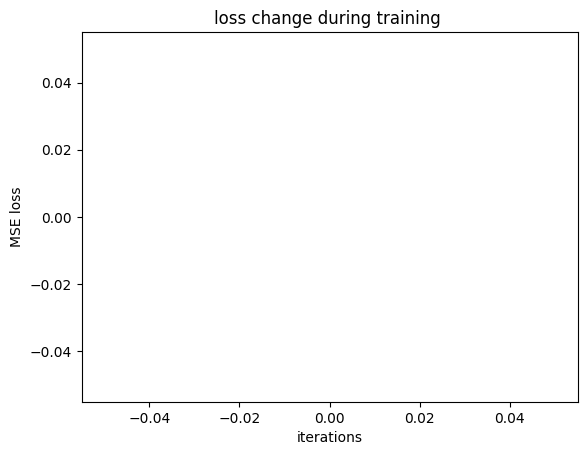

In [62]:
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("MSE loss")
plt.title("loss change during training ")
plt.show()

In [ ]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(zhang_train_dataset), 25, replace=False)
    lab_batch = torch.stack([zhang_train_dataset[i][0] for i in image_inds])
    lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()